# Lab 3: Adversarial Examples Lab

### Introduction

In this lab, we will explore the concept of adversarial examples as introduced in the seminal paper by Goodfellow et al. (2015): "Explaining and Harnessing Adversarial Examples." Adversarial examples are inputs to machine learning models that have been subtly modified to cause the model to make a mistake, while appearing nearly identical to the original input from a human perspective.

### Objectives

1. Understand why neural networks are vulnerable to adversarial examples
2. Implement the Fast Gradient Sign Method (FGSM) to generate adversarial examples
3. Visualize how small, imperceptible perturbations can lead to high-confidence misclassifications

### Implementation

We'll train a simple deep learning model on the MNIST handwritten digit dataset, then apply FGSM to generate adversarial examples that fool our model.

### Setup Instructions

This notebook requires PyTorch and related libraries. If you encounter issues installing these dependencies locally, you can run this notebook in Google Colab, which provides these libraries pre-installed.

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

### Data Loading and Preprocessing

In this section, we set up the data pipeline for our experiment:

1. **Device Configuration**: We determine whether to use GPU (CUDA) or CPU for computation.

2. **Data Transformation**: We apply a simple transformation to convert the MNIST images to PyTorch tensors. Unlike many image classification tasks, we don't normalize the pixel values here because MNIST pixel values are already in the range [0,1] after ToTensor()

3. **Dataset Loading**: We load the MNIST dataset, which consists of 28×28 grayscale images of handwritten digits (0-9).
   - Training set: 60,000 examples
   - Test set: 10,000 examples

4. **DataLoader Creation**: We create DataLoader objects that will feed batches of data to our model during training and evaluation.
   - We use a batch size of 64
   - We shuffle the training data to improve model generalization


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Model training using device: {device}')

transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

batch_size = 64

train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

Model training using device: cuda


### Display Data

Batch shape: torch.Size([64, 1, 28, 28])
Target shape: torch.Size([64])


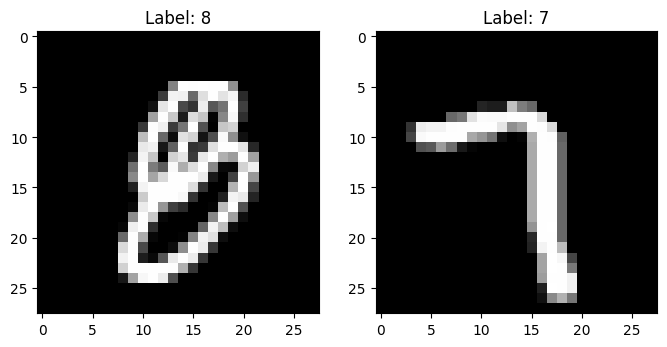

In [21]:
examples = iter(train_loader)
example_data, example_targets = next(examples)

print(f"Batch shape: {example_data.shape}")  # Should be [batch_size, channels, height, width]
print(f"Target shape: {example_targets.shape}")  # Should be [batch_size]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(example_data[0].squeeze(), cmap='gray')
axes[0].set_title(f'Label: {example_targets[0].item()}')
axes[1].imshow(example_data[1].squeeze(), cmap='gray')
axes[1].set_title(f'Label: {example_targets[1].item()}')
plt.show()

### Model Definition

Define a simple neural network for MNIST digit classification. 

Implement a neural network architecture of your choice. For simplicity, we recommend starting with a Multi-Layer Perceptron (MLP) with the following structure:
1. An input layer that flattens the 28x28 MNIST images
2. A hidden layer with 64 neurons and ReLU activation
3. An output layer with 10 neurons (one for each digit 0-9)

For implementation, use PyTorch's nn.Module as the base class and implement:
- The `__init__` method to define your network layers
- The `forward` method to define how data flows through your network

For model components, refer to:
- [torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [torch.nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

<details>
  <summary>Hint 1</summary>
  Remember to flatten the input images in the forward method. MNIST images come in shape [batch_size, 1, 28, 28] and need to be reshaped to [batch_size, 784]. Use x = x.view(x.size(0), -1) for this purpose.
</details>

<details>
  <summary>Hint 2</summary>
  When creating your first linear layer, the input size should be 784 (28×28×1) to match the flattened MNIST images.
</details>

In [ ]:
class CNN_Model(nn.Module):
    def __init__(self, input_shape, cnn_filters, kernel_size, pool_size):
        super().__init__()

        if not len(input_shape) == 4:
            raise ValueError(f"Expected input_shape to have 4 dimensions\
                             [batch_size, channels, height, width], but got {input_shape}")

        self.conv2d = nn.Conv2d(in_channels=input_shape[1], out_channels=cnn_filters, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(pool_size)

        H_out = input_shape[2] - kernel_size + 1
        W_out = input_shape[3] - kernel_size + 1
        linear_input_features = cnn_filters * H_out * W_out
        self.dense = nn.Linear(linear_input_features, 10)

    def forward(self, x):
        x = self.conv2d(x)
        x = self.relu(x)
        x = x.flatten(start_dim=1)
        x = self.dense(x)
        return x

model = CNN_Model(
    input_shape = example_data.shape,
    cnn_filters=30,
    kernel_size=2,
    pool_size=2
).to(device)

### Training the Neural Network

Below is a basic training loop for our MNIST classifier. We use CrossEntropyLoss as our loss function, which is the standard choice for multi-class classification problems. For optimization, we employ SGD (Stochastic Gradient Descent).

The training process consists of:
1. Forward pass through the network
2. Loss calculation
3. Gradient computation via backpropagation
4. Parameter updates using the optimizer

In [23]:
learning_rate = 1e-2

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

num_epochs = 20

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)           # Step 1: Get predictions
        loss = criterion(outputs, labels) # Step 2: Measure error
        # Backward pass and optimize
        optimizer.zero_grad()             # Step 3: Clear old gradients
        loss.backward()                   # Step 4: Compute new gradients
        optimizer.step()                  # Step 5: Update model weights

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/20], Loss: 0.4726
Epoch [2/20], Loss: 0.3206
Epoch [3/20], Loss: 0.2992
Epoch [4/20], Loss: 0.2884
Epoch [5/20], Loss: 0.2798
Epoch [6/20], Loss: 0.2727
Epoch [7/20], Loss: 0.2666
Epoch [8/20], Loss: 0.2605
Epoch [9/20], Loss: 0.2542
Epoch [10/20], Loss: 0.2482
Epoch [11/20], Loss: 0.2417
Epoch [12/20], Loss: 0.2357
Epoch [13/20], Loss: 0.2290
Epoch [14/20], Loss: 0.2215
Epoch [15/20], Loss: 0.2139
Epoch [16/20], Loss: 0.2073
Epoch [17/20], Loss: 0.1989
Epoch [18/20], Loss: 0.1917
Epoch [19/20], Loss: 0.1837
Epoch [20/20], Loss: 0.1763


### Model Evaluation
We evaluate our model's performance by measuring accuracy on the test dataset. This is a simplified approach - in a real environment, we would typically use a separate validation dataset and employ more comprehensive evaluation metrics. However, for the purposes of this notebook, this straightforward evaluation is sufficient to demonstrate the model's baseline performance before we explore adversarial examples.

We’re testing on ‘clean’ images (no tricks yet). A simple MLP should get ~90% accuracy — good, but not perfect.

In [24]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

clean_acc = 100 * correct / total
print(f"Accuracy on clean test images: {clean_acc:.2f}% (expect ~90%)")

Accuracy on clean test images: 95.07% (expect ~90%)


### Comparing Optimizer Performance

For a challenge, try training with Adam, and Adagrad. Plot their losses. Which converges fastest?

Adam Epoch [1/5], Loss: 0.2117
Adam Epoch [2/5], Loss: 0.0808
Adam Epoch [3/5], Loss: 0.0546
Adam Epoch [4/5], Loss: 0.0395
Adam Epoch [5/5], Loss: 0.0334
Adagrad Epoch [1/5], Loss: 0.2451
Adagrad Epoch [2/5], Loss: 0.1239
Adagrad Epoch [3/5], Loss: 0.1039
Adagrad Epoch [4/5], Loss: 0.0923
Adagrad Epoch [5/5], Loss: 0.0832


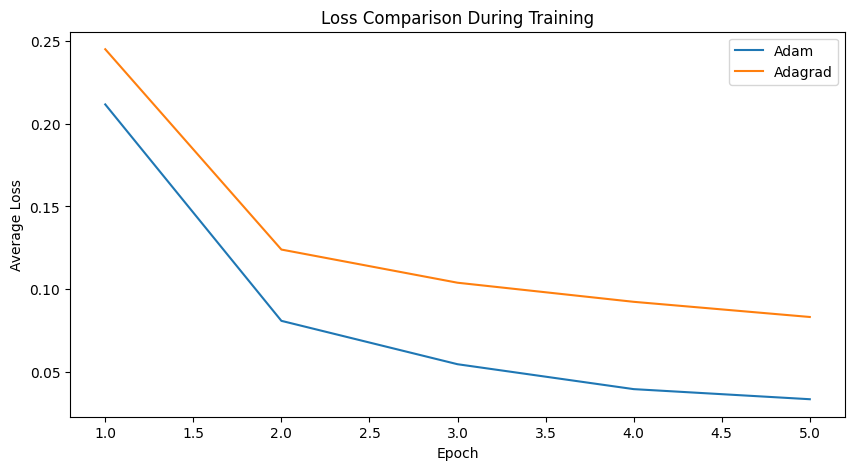

In [25]:
import copy
import matplotlib.pyplot as plt

def train_model(optimizer_type, learning_rate=1e-2, num_epochs=10):
    # Create a copy of the model to train independently
    model_copy = copy.deepcopy(model)
    model_copy.to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_type == 'Adam':
        optimizer = optim.Adam(model_copy.parameters(), lr=learning_rate)
    elif optimizer_type == 'Adagrad':
        optimizer = optim.Adagrad(model_copy.parameters(), lr=learning_rate)
    else:
        raise ValueError("Unsupported optimizer type")

    loss_history = []
    model_copy.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            # Forward pass
            images, labels = images.to(device), labels.to(device)
            outputs = model_copy(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"{optimizer_type} Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    return model_copy, loss_history

# Train with Adam optimizer
adam_model, adam_losses = train_model('Adam', learning_rate, num_epochs=5)

# Train with Adagrad optimizer
adagrad_model, adagrad_losses = train_model('Adagrad', learning_rate, num_epochs=5)

# Visualize losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), adam_losses, label='Adam')
plt.plot(range(1, 6), adagrad_losses, label='Adagrad')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Loss Comparison During Training')
plt.legend()
plt.show()


#### Observation: 
Adam converges to a lower loss faster.

### Model Evaluation
Repeat model evaluation for Adam optimizer.

In [29]:
adam_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = adam_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

clean_acc = 100 * correct / total
print(f"Accuracy on clean test images: {clean_acc:.2f}% (expect ~90%)")

Accuracy on clean test images: 97.28% (expect ~90%)


### FGSM Attack
Implement FGSM attack.

In [38]:
default_epsilon = 0.15

def fgsm_attack(
    model: nn.Module, images: torch.Tensor, labels: torch.Tensor, epsilon: float = default_epsilon
) -> torch.Tensor:
    """
    Creates adversarial examples via the FGSM method:
    x_adv = x + epsilon * sign( dJ/dx ).
    """
    images = images.clone().detach().to(device)
    labels = labels.to(device)

    # Ensure gradients are being tracked
    images.requires_grad = True

    criterion = nn.CrossEntropyLoss()

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass and optimize
    model.zero_grad()
    loss.backward()

    # Collect the element-wise sign of gradient
    data_grad_sign = images.grad.data.sign()

    # Create the perturbed images
    perturbed_images = images + epsilon * data_grad_sign

    # Clamp the perturbed images to [0,1]
    perturbed_images = torch.clamp(perturbed_images, 0, 1)

    return perturbed_images

### Calculate accuracy for adversarial examples

In [43]:
correct = 0
total = 0
for images, labels in test_loader:
    # Generate adversarial images
    adv_images = fgsm_attack(adam_model, images, labels, default_epsilon)

    # Re-classify
    outputs = adam_model(adv_images.to(device))
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum().item()

adv_acc = 100 * correct / total
print(f"Accuracy on adversarial test images (FGSM, eps={default_epsilon}): {adv_acc:.2f}%")

Accuracy on adversarial test images (FGSM, eps=0.15): 7.78%


### Display adversarial examples

Let's compare original and adversarial images side-by-side.

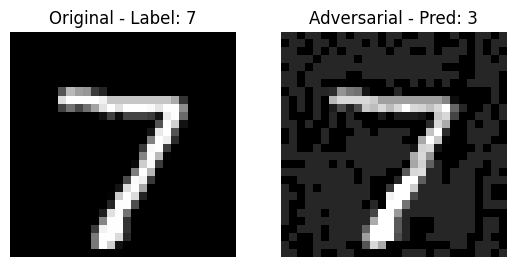

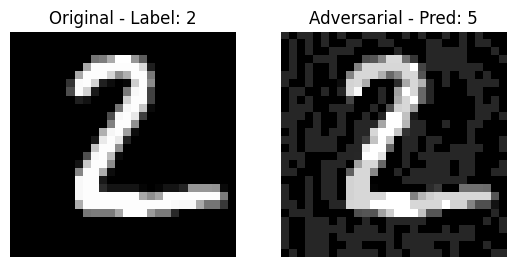

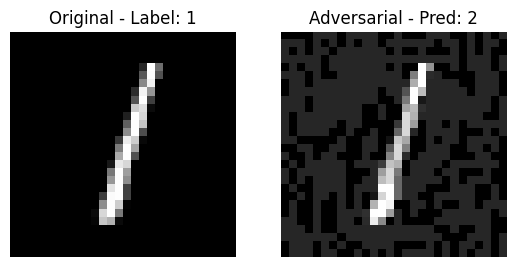

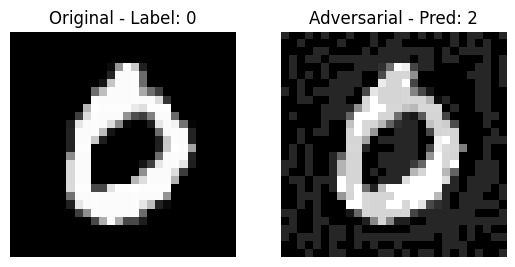

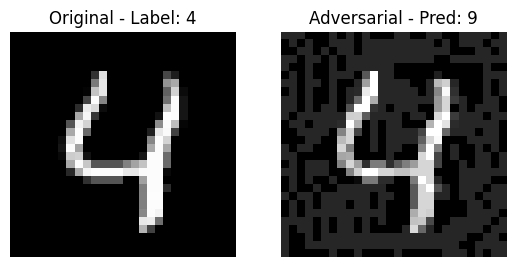

In [44]:
examples = iter(test_loader)
example_images, example_labels = next(examples)
example_images = example_images[:5]
example_labels = example_labels[:5]

adv_ex = fgsm_attack(model, example_images, example_labels, default_epsilon)

for i in range(5):
    plt.figure()

    plt.subplot(1, 2, 1)
    plt.title(f"Original - Label: {example_labels[i].item()}")
    plt.imshow(example_images[i][0].cpu(), cmap="gray")
    plt.axis("off")

    adv_label_out = model(adv_ex[i].unsqueeze(0))
    _, adv_pred = torch.max(adv_label_out, 1)
    plt.subplot(1, 2, 2)
    plt.title(f"Adversarial - Pred: {adv_pred.item()}")
    plt.imshow(adv_ex[i][0].detach().cpu(), cmap="gray")
    plt.axis("off")

    plt.show()

### Epsilon Parameter Analysis
 In this section, you'll analyze how the epsilon parameter affects the effectiveness of adversarial examples. The epsilon parameter controls the magnitude of the perturbation applied to the original images.

**Task:**
1. Evaluate the model's accuracy on adversarial examples generated with different epsilon values (try at least 5 different values)
2. Create a line plot showing model accuracy (y-axis) vs. epsilon value (x-axis)
3. Discuss the trade-off between:
- Visual perceptibility of the perturbations (higher epsilon = more visible changes)
- Attack success rate (higher epsilon = more successful attacks = lower model accuracy)

Epsilon: 0.00 	 Accuracy: 97.28%
Epsilon: 0.05 	 Accuracy: 60.08%
Epsilon: 0.10 	 Accuracy: 25.48%
Epsilon: 0.15 	 Accuracy: 7.78%
Epsilon: 0.20 	 Accuracy: 1.90%


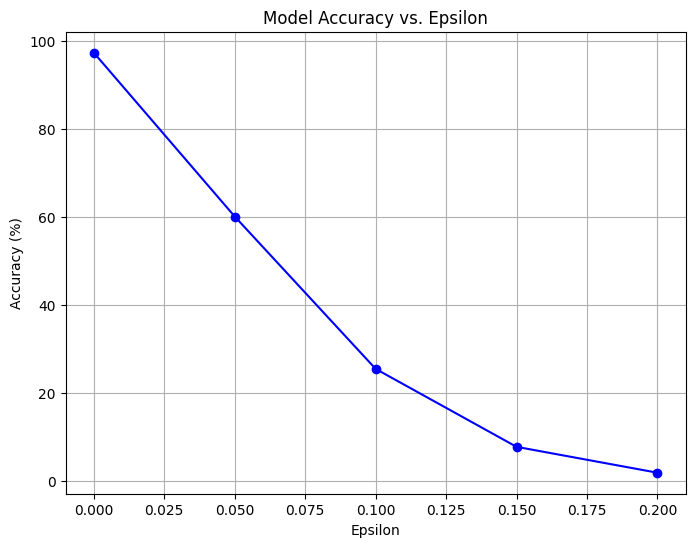

In [42]:
# List of epsilon values to test (at least 5 different values)
epsilon_values = [0.0, 0.05, 0.1, 0.15, 0.2]
accuracies = []

# Evaluate the model's accuracy on adversarial examples for each epsilon value
for eps in epsilon_values:
    correct = 0
    total = 0
    for images, labels in test_loader:
        # Generate adversarial examples using the current epsilon
        adv_images = fgsm_attack(adam_model, images, labels, eps)

        # Re-classify the adversarial examples
        outputs = adam_model(adv_images.to(device))
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

    acc = 100 * correct / total
    accuracies.append(acc)
    print(f"Epsilon: {eps:.2f} \t Accuracy: {acc:.2f}%")

# Create plot: Accuracy vs. Epsilon
plt.figure(figsize=(8, 6))
plt.plot(epsilon_values, accuracies, marker='o', linestyle='-', color='blue')
plt.title('Model Accuracy vs. Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

## Results
As we can see, with small changes in Epsilon, model accuracy drops drasticly. This highlights the delicate balance between the indistinctness of the perturbation and the effectiveness of the attack.